In [1]:
%pip install torchfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchfm: filename=torchfm-0.7.0-py3-none-any.whl size=18358 sha256=1cfdc6f609bf73102848a92709303d4dd32719b1ea5b0c3d552b204b830c4862
  Stored in directory: /root/.cache/pip/wheels/5e/e9/25/1ae407681ff67b4334513b7793ced4c66a4bf37ee99ed31ffe
Successfully built torchfm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate

In [2]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi']= 150

In [3]:
data = pd.read_csv('/content/drive/MyDrive/recsys_data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [4]:
data.drop(["banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1", "campaign_clicks"], axis=1, inplace=True)

In [5]:
data

,date_time,zone_id,banner_id,oaid_hash,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,1,0,1,1
...,...,...,...,...,...,...,...,...
15821467,2021-10-02 15:51:35.000000,146,530,4329496688011613719,2,9,1,0
15821468,2021-09-27 22:03:14.000000,12,22,453968700792456599,1,6,1,0
15821469,2021-10-02 17:41:10.000000,12,1236,9112780675655118328,2,0,1,0
15821470,2021-09-29 00:39:32.000000,967,21,6968514095695555037,0,0,1,0


In [6]:
unique_users = np.unique(data.oaid_hash)

In [7]:
len(unique_users), len(data) / len(unique_users)

(6510316, 2.430215676166871)

**Посчитаем статистику для фичей, где это имеет смысл. Построим гистограммы и посчитаем уникальные значения для категориальных признаков**

In [8]:
def analysis(data: pd.DataFrame):
    print(data[["impressions", "clicks",]].describe())
    for field in ["zone_id", "banner_id", "os_id", "country_id",]:
        print(f"Unique {field}:", len(np.unique(data[field])))
        plt.hist(data[field], bins=min(30, len(np.unique(data[field]))))
        plt.show()

       impressions        clicks
count   15821472.0  1.582147e+07
mean           1.0  2.668835e-02
std            0.0  1.611710e-01
min            1.0  0.000000e+00
25%            1.0  0.000000e+00
50%            1.0  0.000000e+00
75%            1.0  0.000000e+00
max            1.0  1.000000e+00
Unique zone_id: 3444


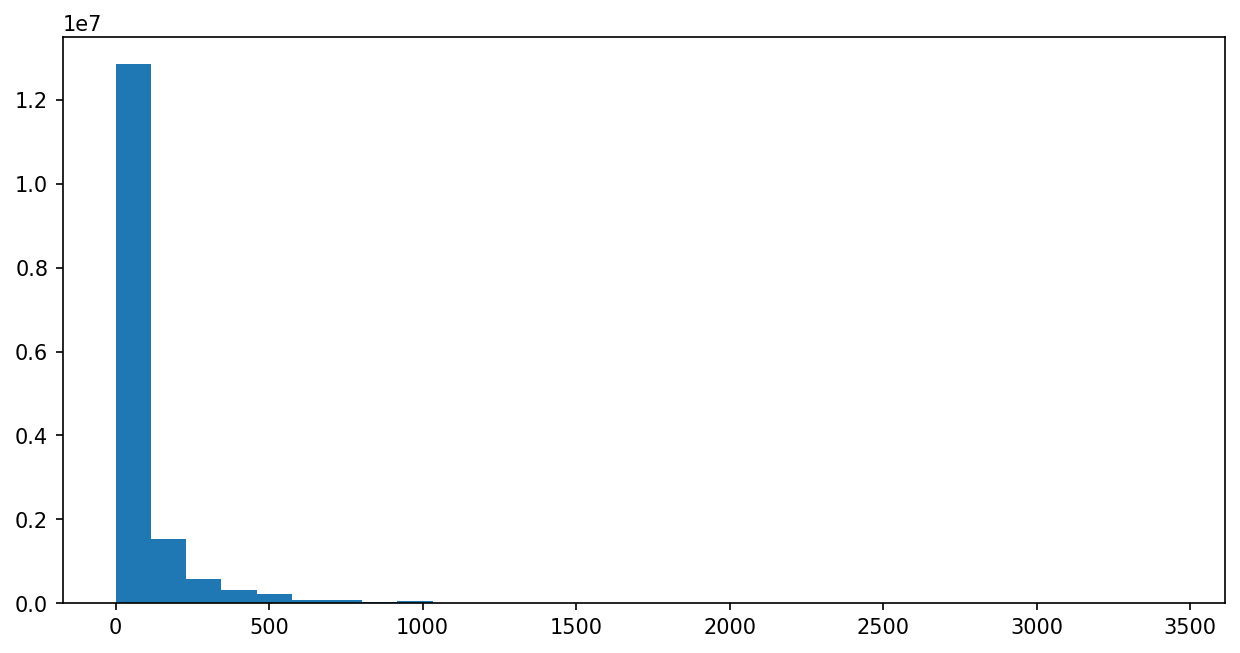

Unique banner_id: 1633


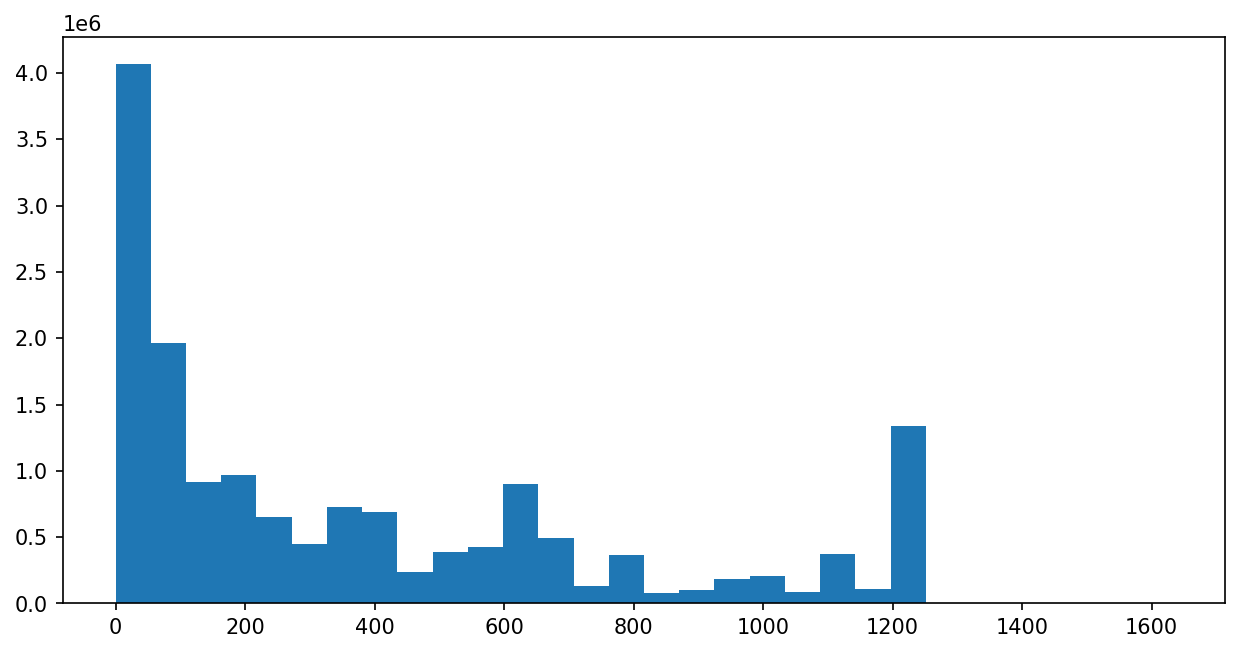

Unique os_id: 11


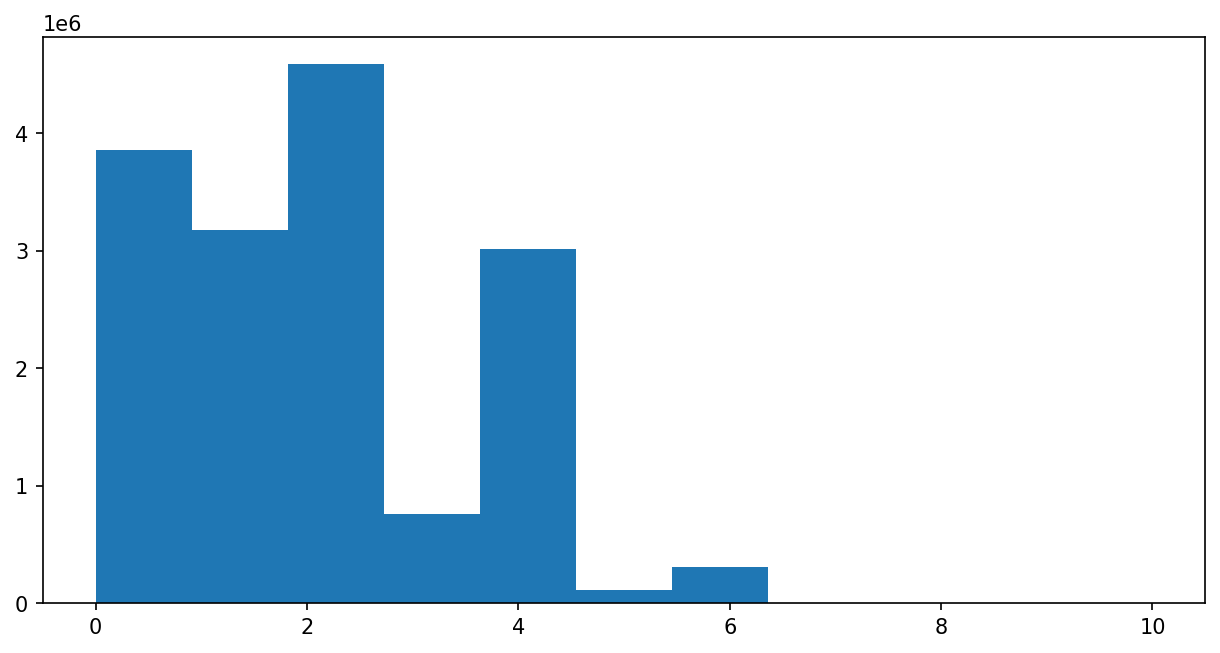

Unique country_id: 17


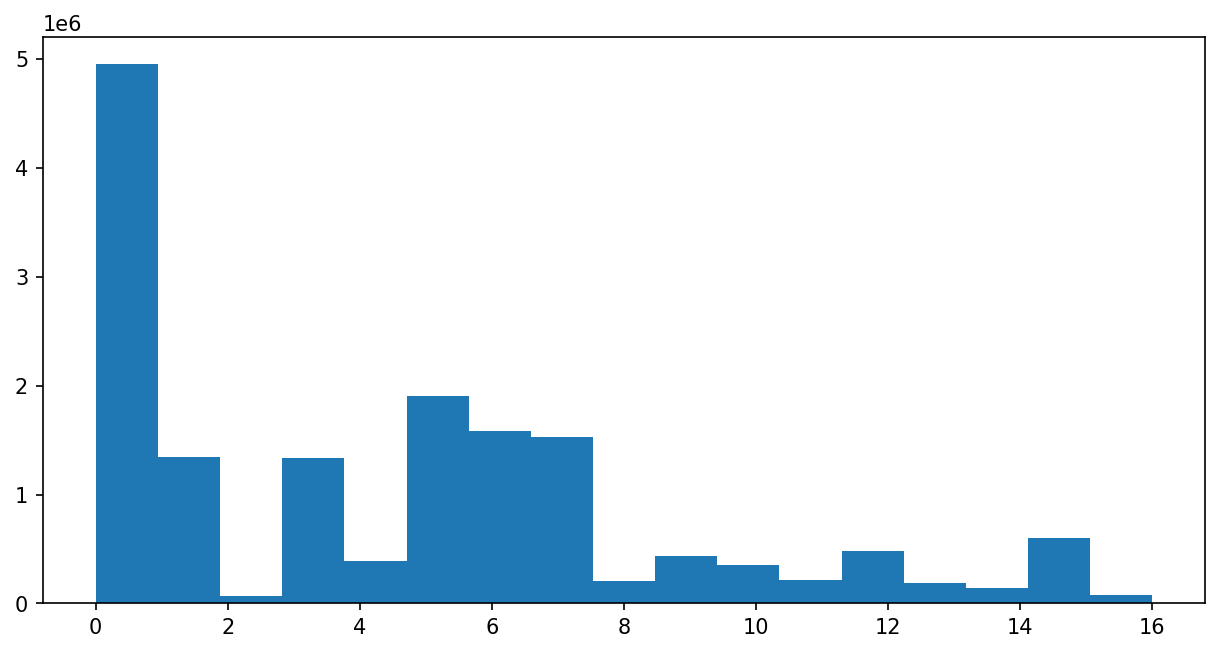

In [9]:
analysis(data)

In [10]:
categorical_features = ["zone_id", "banner_id", "os_id", "country_id", "oaid_hash"]

**У некоторых категориальных фичей много различных значений (из рассмотрения убираем хеш пользователя, т.к. он важен для данного задания). Часть категорий встречается очень редко. Объединим редкие категории в одну (редкость определяется константой FITLERING_FRACTION), это упростит дальнейшую работу, т.к. иначе данные могут начать занимать много места, а обучение алгоритмов потребует большего количества времени**

In [11]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    FITLERING_FRACTION = 0.05
    RELABEL = 100000000000
    size = len(data)
    threshold = size * FITLERING_FRACTION
    
    for field in categorical_features:
        if field in ['banner_id', 'oaid_hash']:
            continue
        print(field)
        uniques = np.unique(data[field])
        mapping = {i: i for i in uniques}
        for val in uniques:
            ids = data[field] == val 
            if np.sum(ids) < threshold:
                mapping[val] = RELABEL
        data[field] = data[field].map(mapping)
    
    for field in categorical_features:
        print(field)
        uniques = np.unique(data[field])
        mapping = {v: i for i, v in enumerate(uniques)}
        data[field] = data[field].map(mapping)
    
#     for field in categorical_features:
#         one_hot = pd.get_dummies(data[field])
#         data = data.drop(field,axis = 1)
#         data = data.join(one_hot, lsuffix=f"{field}_")
    return data

In [12]:
data = feature_engineering(data)

zone_id
os_id
country_id
zone_id
banner_id
os_id
country_id
oaid_hash


In [13]:
# data.to_csv("data_features_1.csv", index=False)

In [14]:
# !cp ./data_features_1.csv /content/drive/MyDrive/

In [15]:
data

,date_time,zone_id,banner_id,oaid_hash,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,2,0,3995055,0,0,1,1
1,2021-09-26 22:54:49.000000,2,1,3658117,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,1563002,0,0,1,1
3,2021-09-27 00:04:30.000000,2,3,4418226,1,1,1,1
4,2021-09-27 00:06:21.000000,2,4,3370227,1,0,1,1
...,...,...,...,...,...,...,...,...
15821467,2021-10-02 15:51:35.000000,2,530,3053210,2,6,1,0
15821468,2021-09-27 22:03:14.000000,2,22,320605,1,4,1,0
15821469,2021-10-02 17:41:10.000000,2,1236,6431382,2,0,1,0
15821470,2021-09-29 00:39:32.000000,2,21,4917002,0,0,1,0


**Посчитаем размерности филдов**

In [16]:
field_dims = [np.max(data[k]) + 1 for k in ["zone_id", "banner_id", "oaid_hash", "os_id", "country_id", "impressions"]]

In [17]:
field_dims

[3, 1633, 6510316, 5, 7, 2]

**Разделим данные на обучающую выборку и тестовую (последний день лога) по дате и выкинем эту фичу, т.к. не хочется захламлять фичи по указанным ранее причинам**

In [18]:
max(data["date_time"])

'2021-10-02 23:59:59.000000'

In [19]:
max_date = "2021-10-02"

In [20]:
last_day_data = data[data.date_time.apply(lambda d: max_date in d)]

In [21]:
data.drop(last_day_data.index, inplace=True)

In [22]:
data.drop(["date_time"], axis=1, inplace=True)
last_day_data.drop(["date_time"], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
data

,zone_id,banner_id,oaid_hash,os_id,country_id,impressions,clicks
0,2,0,3995055,0,0,1,1
1,2,1,3658117,0,1,1,1
2,2,2,1563002,0,0,1,1
3,2,3,4418226,1,1,1,1
4,2,4,3370227,1,0,1,1
...,...,...,...,...,...,...,...
15821465,2,159,6298248,0,6,1,0
15821466,0,254,222449,0,3,1,0
15821468,2,22,320605,1,4,1,0
15821470,2,21,4917002,0,0,1,0


**Расчехляем Torch**

**Пишем датасет для итерированию по данным**

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader

In [25]:
class ClicksDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = float(row['clicks'])
        features = row.drop(['clicks']).to_numpy()
        return features, label

**Разобъем тренировачные данные на train/val чтобы оценивать качество модели не используя последний день**

In [26]:
np.random.seed(0)
idxs = np.arange(len(data))
np.random.shuffle(idxs)
train_set = data.iloc[idxs[:int(0.8 * len(idxs))]]
val_set = data.iloc[idxs[int(0.8 * len(idxs)):]]

In [27]:
train_dataset = ClicksDataset(train_set)
val_dataset = ClicksDataset(val_set)

In [28]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=2)

**Строим FFM модель, оптимизатор и критерий для оптимизации, в нашем случае биннарная кросс энтропия**

In [29]:
from torchfm.model.ffm import FieldAwareFactorizationMachineModel

In [40]:
model = FieldAwareFactorizationMachineModel(field_dims, 5).cuda()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
criterion = torch.nn.BCELoss()

In [30]:
from tqdm import tqdm

**Обучаемся. Одна эпоха заниамет много времени, поэтому проитерируемся по данным один раз**

In [43]:
n_epochs = 1

for e in range(n_epochs):
    pbar = tqdm(enumerate(train_loader))
    for i, (features, labels) in pbar:
            features = torch.LongTensor(features).to('cuda')
            labels = labels.float().to('cuda')
            pred = model(features)
            loss = criterion(pred, labels)
            loss.backward()
            optim.step()
            optim.zero_grad()
            pbar.set_description(f"Training loss {i}: {loss.cpu().detach().item()}")

Training loss 10697: 0.10288738459348679: : 10698it [1:09:16,  2.57it/s]


In [45]:
model.cpu()
torch.save(model.state_dict(), "trained.cpt")

In [47]:
!cp trained.cpt ./drive/MyDrive/

In [46]:
model.load_state_dict(torch.load("trained.cpt"))
model.cuda()
model.eval()

FieldAwareFactorizationMachineModel(
  (linear): FeaturesLinear(
    (fc): Embedding(6511966, 1)
  )
  (ffm): FieldAwareFactorizationMachine(
    (embeddings): ModuleList(
      (0): Embedding(6511966, 5)
      (1): Embedding(6511966, 5)
      (2): Embedding(6511966, 5)
      (3): Embedding(6511966, 5)
      (4): Embedding(6511966, 5)
      (5): Embedding(6511966, 5)
    )
  )
)

**Оценим модель на валидации**

In [50]:
y_true = []
y_pred = []

for features, labels in tqdm(val_loader):
        features = torch.LongTensor(features).to('cuda')
        y_true += labels.tolist()
        pred = model(features)
        y_pred += pred.detach().cpu().tolist()

0it [00:00, ?it/s]

0it [00:23, ?it/s]


  0%|          | 1/2675 [00:03<2:35:43,  3.49s/it]

  0%|          | 3/2675 [00:04<51:17,  1.15s/it]  

  0%|          | 5/2675 [00:05<39:37,  1.12it/s]

  0%|          | 7/2675 [00:06<28:45,  1.55it/s]

  0%|          | 9/2675 [00:07<28:07,  1.58it/s]

  0%|          | 13/2675 [00:08<17:41,  2.51it/s]

  1%|          | 15/2675 [00:08<17:15,  2.57it/s]

  1%|          | 17/2675 [00:09<19:33,  2.26it/s]

  1%|          | 19/2675 [00:11<23:12,  1.91it/s]

  1%|          | 21/2675 [00:11<20:07,  2.20it/s]

  1%|          | 23/2675 [00:12<17:47,  2.48it/s]

  1%|          | 24/2675 [00:13<20:41,  2.13it/s]

  1%|          | 26/2675 [00:14<19:27,  2.27it/s]

  1%|          | 29/2675 [00:14<16:08,  2.73it/s]

  1%|          | 31/2675 [00:15<16:09,  2.73it/s]

  1%|          | 33/2675 [00:16<16:02,  2.75it/s]

  1%|▏         | 35/2675 [00:16<15:51,  2.77it/s]

  1%|▏         | 37/2675 [00:17<15:54,  2.76it/s]

  1%|▏         | 39/2675 [00:18<15:57,  2.

In [37]:
from sklearn.metrics import log_loss, roc_auc_score

**Качество получилось очень хорошим в сравненнии с прошлым заданием**

In [53]:
print("FFM validation score")
print("Log loss", log_loss(y_true, y_pred))
print("ROC AUC", roc_auc_score(y_true, y_pred))

FFM validation score
Log loss 0.10800191159358837
ROC AUC 0.770631357810076


**Теперь обучимся на всем наборе данных и оценимся на последнем дне**

In [31]:
train_dataset = ClicksDataset(data)
val_dataset = ClicksDataset(last_day_data)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=2)

In [32]:
model = FieldAwareFactorizationMachineModel(field_dims, 5).cuda()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
criterion = torch.nn.BCELoss()

In [33]:
n_epochs = 1

for e in range(n_epochs):
    pbar = tqdm(enumerate(train_loader))
    for i, (features, labels) in pbar:
            features = torch.LongTensor(features).to('cuda')
            labels = labels.float().to('cuda')
            pred = model(features)
            loss = criterion(pred, labels)
            loss.backward()
            optim.step()
            optim.zero_grad()
            pbar.set_description(f"Training loss {i}: {loss.cpu().detach().item()}")

Training loss 13371: 0.10038017481565475: : 13372it [1:26:11,  2.59it/s]


In [34]:
model.cpu()
torch.save(model.state_dict(), "trained_full.cpt")

In [35]:
!cp trained_full.cpt ./drive/MyDrive/

In [36]:
model.load_state_dict(torch.load("trained_full.cpt"))
model.cuda()
model.eval()

FieldAwareFactorizationMachineModel(
  (linear): FeaturesLinear(
    (fc): Embedding(6511966, 1)
  )
  (ffm): FieldAwareFactorizationMachine(
    (embeddings): ModuleList(
      (0): Embedding(6511966, 5)
      (1): Embedding(6511966, 5)
      (2): Embedding(6511966, 5)
      (3): Embedding(6511966, 5)
      (4): Embedding(6511966, 5)
      (5): Embedding(6511966, 5)
    )
  )
)

In [38]:
y_true = []
y_pred = []

for features, labels in tqdm(val_loader):
        features = torch.LongTensor(features).to('cuda')
        y_true += labels.tolist()
        pred = model(features)
        y_pred += pred.detach().cpu().tolist()

100%|██████████| 2080/2080 [12:14<00:00,  2.83it/s]


**Качество сопостовимо с тем что видели в прошлом задании, если потюнить параметры и подольше поучить, то точно можно выбить скоры повыше**

In [40]:
print("FFM last day score")
print("Log loss", log_loss(y_true, y_pred))
print("ROC AUC", roc_auc_score(y_true, y_pred))

FFM last day score
Log loss 0.15464581918234746
ROC AUC 0.7325637698400447
